# Chapter 8: Hierarchical Clustering

In [ ]:
low_memory=False
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## 8.1 Introduction & Motivation

The k-Means algorithm is excellent at detecting clusters when we know beforehand exactly how many clusters we expect to find. However, as we've seen, it becomes more challenging when the number of clusters is unknown. We could calculate evaluation metrics (like we did with the elbow method), fit multiple k-Means models with different k values, and compare them all. Alternatively, we can use **Hierarchical Clustering**, which offers a more flexible approach.

**Key Advantage:** Hierarchical clustering doesn't require us to specify the number of clusters upfront. Instead, it creates a hierarchy of clusters that we can cut at any level to get our desired number of groups.

## 8.2 Problem Setting

We're continuing to work with the unsupervised version of the digits dataset from the previous chapter. As a reminder:

This allows us to compare how hierarchical clustering performs compared to k-Means on the same problem.

* **Dataset:** Handwritten digits (0-9)

* **Features:** 64 variables representing pixel intensities in 8x8 images* **Task:** Group similar digits together without using the true labels
* **Observations:** 1,797 digit images

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

## 8.3 Model

### 8.3.1 Model

The idea behind hierarchical clustering is remarkably simple and intuitive. Consider the following dataset:

![](https://s3.amazonaws.com/stackabuse/media/hierarchical-clustering-python-scikit-learn-1.png)

We can clearly see two clusters in this visualization, but we need an algorithm to identify them systematically. Here's how **agglomerative (bottom-up) hierarchical clustering** works:

**Result:** We create a hierarchy that contains solutions for every possible number of clusters (from n down to 1). This process can be visualized as follows: 

**Step-by-Step Process:**

1. **Start:** Each observation begins as its own cluster (n clusters for n points)
2. **Measure:** Calculate the distance between all pairs of clusters
3. **Merge:** Combine the two closest clusters into one
4. **Repeat:** Continue steps 2-3 until all points are in a single cluster

![](https://s3.amazonaws.com/stackabuse/media/hierarchical-clustering-python-scikit-learn-2.png)

The power of hierarchical clustering lies in its flexibility. We can "cut" the dendrogram (tree diagram) at any height to obtain our desired number of clusters. The horizontal line we draw across the tree determines how many clusters we end up with:

This visual approach makes it easy to choose the optimal number of clusters:

* **Cut high:** Fewer, larger clusters
* **Cut low:** More, smaller clusters

![](https://s3.amazonaws.com/stackabuse/media/hierarchical-clustering-python-scikit-learn-4.png)

### 8.3.2 Model Estimation

Let's create a dendrogram to visualize the hierarchical structure of our digits dataset:

**Note:** A dendrogram is a tree diagram that shows the arrangement of clusters. The height at which branches merge indicates the distance between clusters.

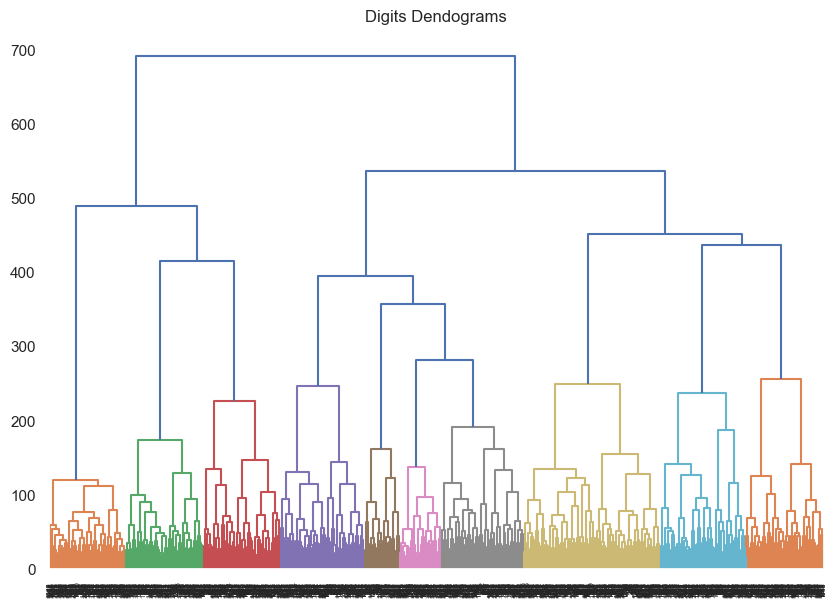

In [6]:
plt.figure(figsize=(10, 7))
plt.title("Digits Dendograms")
Z = shc.linkage(digits.data, method='ward')
dend = shc.dendrogram(Z, color_threshold=280)

**Interpreting the Dendrogram:**

Ideally, we draw our cutoff line where there's the largest vertical distance without any merges occurring. This represents a natural separation between clusters.

**For this example:** Since we know there are 10 distinct digits (0-9), we'll fit our model with 10 clusters:

One of the key advantages of hierarchical clustering is its flexibility: if certain digits are too similar and get confused, we can easily adjust by choosing a different number of clusters to improve separation.

In [5]:
cluster = AgglomerativeClustering(n_clusters=10, linkage='ward')
cluster.fit_predict(digits.data)

array([7, 9, 4, ..., 4, 1, 4])

## 8.4 Exercises

##### Question 1: Try to fit the elbow plot for the hierarchical clustering model on the digits dataset.

**Understanding the Metrics:**

**Hint:** The Ward method is generally preferred because it creates compact, spherical clusters similar to k-Means.

For k-Means, we used the distortion (inertia) metric to create elbow plots. However, hierarchical clustering doesn't use centroids, so distortion isn't applicable here.

* **Average linkage**: Uses the average distance between all pairs

Instead, we use the **Linkage Criterion**, which represents the distance between clusters before they merge. The specific calculation depends on the linkage method:
* **Complete linkage**: Uses the maximum distance between cluster members

* **Ward linkage** (most common): Minimizes the variance within clusters

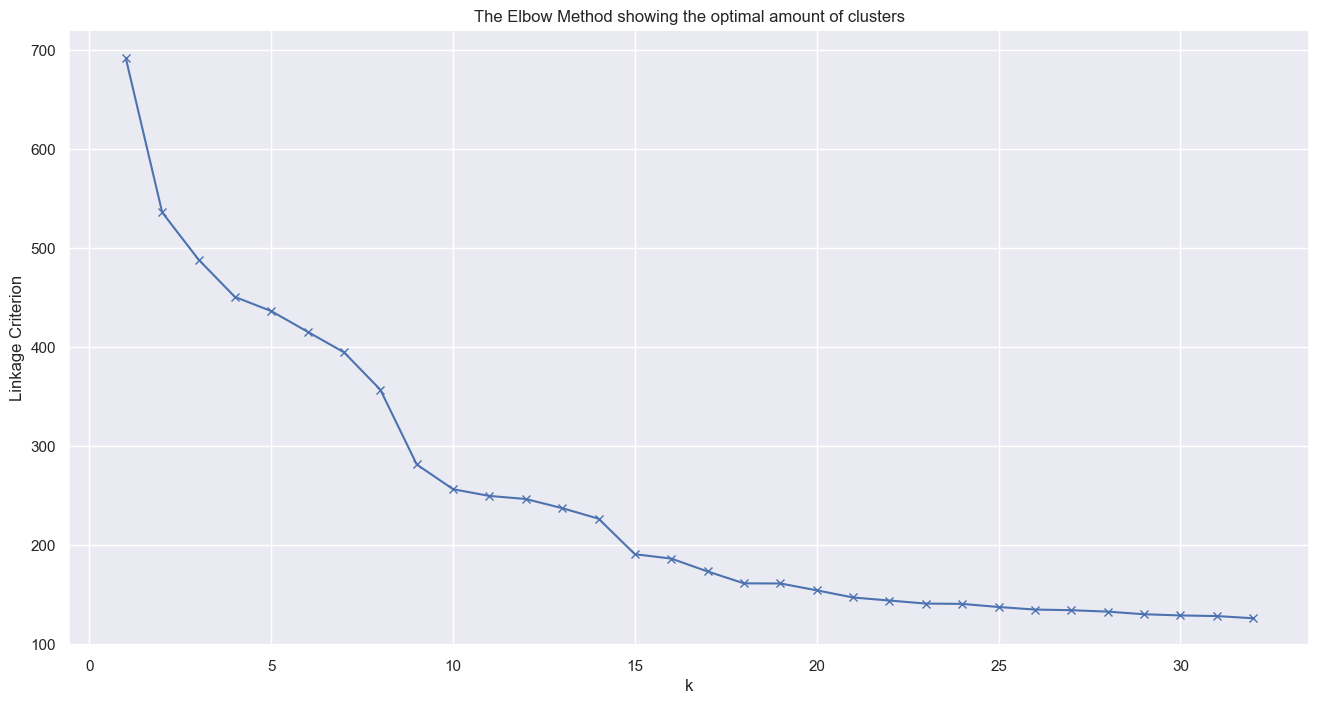

In [20]:
Z = shc.linkage(digits.data, method='ward')

# Elbow method: Take last 32 distances and reverse them to match the increasing amount of clusters
last = Z[-32:, 2]
last_rev = last[::-1]

plt.figure(figsize=(16,8))
plt.plot(range(1,33), last_rev, 'bx-')
plt.xlabel('k')
plt.ylabel('Linkage Criterion')
plt.title('The Elbow Method showing the optimal amount of clusters')
plt.show()

**Analyzing the Elbow Plot:**

Notice that this graph "wobbles" significantly more than the elbow plots we've seen with k-Means. This is normal for hierarchical clustering because it captures more subtle variations in the clustering structure.

**Practical Insight:** The flexibility to choose between 9 or 10 clusters demonstrates how hierarchical clustering lets us balance between capturing all distinct groups versus merging very similar ones.

**Key Observations:**

* The value of **10 clusters** sits in the middle of the elbow, confirming this is optimal for our dataset* This makes sense given that some digits are very similar (e.g., '1' and '7', or '3' and '8')
* Interestingly, **9 clusters** would also be a reasonable choice

##### Question 2: Try to split the dataset between test and train and check how accurate the best possible hierarchical clustering model is.

In [22]:
from scipy.stats import mode

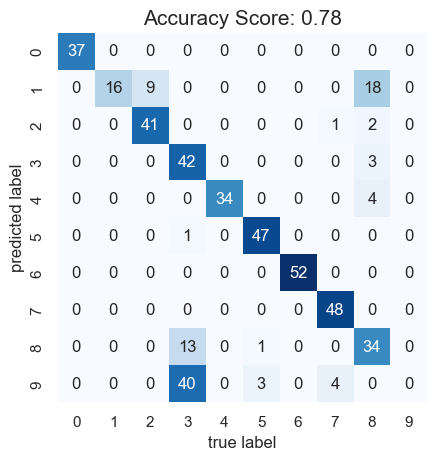

In [24]:
digits = load_digits()
digits.data.shape

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

hierCluster = AgglomerativeClustering(n_clusters=10, linkage='ward')
clusters = hierCluster.fit_predict(X_test)

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(y_test[mask])[0]

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

score = accuracy_score(labels, y_test)
cm = confusion_matrix(y_test, labels)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, xticklabels=digits.target_names, yticklabels=digits.target_names, cmap="Blues")
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title(all_sample_title, size = 15);

**Model Performance:**

**Context:** This accuracy is actually **3% better** than the k-Means result from the previous chapter (75%), suggesting that hierarchical clustering may be better suited for this particular dataset.

We achieve an accuracy of **78%** on the test set. This is quite impressive considering:

* The model had no access to the true digit labels during training* We're evaluating on completely unseen data
* It discovered the cluster structure purely from pixel patterns

##### Question 3: Compare the hierarchical clustering and the $k$ means clustering algorithm for this dataset. Report. Which one provides the best fit? Is this what you would expect?

**Comparative Analysis:**

**Performance Results:**

* Hierarchical clustering: **78% accuracy**

**Takeaway:** While we knew k=10 was optimal, the sensitivity to initial centroids in k-Means made it perform slightly worse than the deterministic hierarchical approach.

* k-Means clustering: **75% accuracy**

* **Winner:** Hierarchical clustering performs 3% better
* When speed is more important than slight accuracy gains

* Clearly separated, spherical clusters

**Why Hierarchical Clustering Wins Here:**
* Very large datasets (hierarchical clustering is computationally expensive)

**When k-Means Might Be Better:**

1. **No initialization randomness:** Unlike k-Means, hierarchical clustering is deterministic and not sensitive to initial starting positions

2. **Flexible cluster shapes:** It can handle clusters of varying shapes and sizes better than k-Means
3. **Better for complex data:** The digits dataset has subtle variations in handwriting that hierarchical clustering captures more effectively